This compressed notebook focuses solely on demonstrating the modeling approach.

## Load libraries

In [15]:
import pandas as pd # load and manipulate data
import numpy as np # calculation
import matplotlib.pyplot as plt # visualize data
from sklearn.preprocessing import OneHotEncoder # To one-hot encode variables
import category_encoders as ce # To target encode high cardinality variables
from datetime import datetime
# to build the model
import xgboost as xgb
from xgboost import XGBRegressor

## Load processed data

In [13]:
# Read the CSV file, ignoring the first column
demand = pd.read_csv('processed_data.csv', encoding='latin1', usecols=lambda column: column != 'Unnamed: 0')

In [18]:
# Ensure the 'date' column is in datetime format
demand['date'] = pd.to_datetime(demand['date'])

# Sort the data by date, then product_id
demand = demand.sort_values(by=['date'])

## Modeling

### Define features and target

In [10]:
# Review all variables
demand.columns.tolist()

['date',
 'product_name',
 'traffic',
 'impressions',
 'payment',
 'revenue',
 'product_ad_spend',
 'shop_ad_spend',
 'product_page_bounce_count',
 'traffic_from_search',
 'run_product_ad',
 'run_shop_ad',
 'conversion_rate',
 'wm_yr_wk',
 'wday',
 'month',
 'd',
 'doubleday',
 'near_dday',
 'end_of_month',
 'weekend',
 'other_commercial_sale',
 'day_offs',
 'day_of_year',
 'week_of_month',
 'est_avg_price',
 'avg_price',
 'promotion_on',
 'promotion_price',
 'discount_rate',
 'comment_received',
 'product_rating',
 'avg_category_comment',
 'avg_category_rate',
 'high_rating',
 'high_comment',
 'high_discount',
 'wday_sin',
 'wday_cos',
 'month_sin',
 'month_cos',
 'wom_sin',
 'wom_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'payment_lag_3',
 'payment_lag_28',
 'revenue_lag_3',
 'revenue_lag_28',
 'product_ad_spend_lag_3',
 'product_ad_spend_lag_28',
 'shop_ad_spend_lag_3',
 'shop_ad_spend_lag_28',
 'traffic_rolling_7d_mean',
 'impressions_rolling_7d_mean',
 'payment_rolling_7d_mean

#### Exclude some variables out of features used for training:
* Prevent data leakage: Ensure that information unavailable at prediction time is not included in the training process.
* Avoid duplication: Eliminate redundant features that may skew the model's learning.
* Align with learning objectives: Select features based on the specific goals of the model.

In [19]:
exclude_cols = ['date', 'product_name', 'conversion_rate', 'payment', 'revenue_rolling_28d_mean', 'revenue_rolling_7d_mean', 'revenue_lag_28', 'revenue_lag_3', 'd', 'revenue']  # Adjust as needed
features = [col for col in demand.columns if col not in exclude_cols]
target = 'payment'

## Cross-validation
Train on historical data up to some month, validate on the next month.
* To fine-tune model hyperparameters
* To see stability in RMSE score through each folds to see if the model is stable across months, meaning the model generalizes well.

In [20]:
# Helper function for creating CV folds while reserving time order
def split_by_month(df, train_end_month, val_month, features, target):
    train_end = pd.to_datetime(train_end_month + '-01') + pd.offsets.MonthEnd(1)
    val_start = pd.to_datetime(val_month + '-01')
    val_end = val_start + pd.offsets.MonthEnd(1)

    train_df = df[df['date'] <= train_end]
    val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

    X_train = train_df[features]
    y_train = train_df[target]
    X_val = val_df[features]
    y_val = val_df[target]

    # Create sample weights for training data to boost doubleday
    sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

    return X_train, y_train, X_val, y_val, sample_weights

# ---- TIME-BASED CROSS-VALIDATION ----

train_end_month_list = ['2024-07', '2024-08', '2024-09', '2024-10', '2024-11']
val_month_list       = ['2024-08', '2024-09', '2024-10', '2024-11', '2024-12']

cv_rmse_scores = []

for train_end, val_month in zip(train_end_month_list, val_month_list):
    X_train, y_train, X_val, y_val, sample_weights = split_by_month(demand, train_end, val_month, features, target)

    # Convert to numeric/categorical/bool only, if needed
    X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
    X_val = X_val.select_dtypes(include=[np.number, 'category', 'bool'])

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        #'n_estimators': 1000,
        #'early_stopping_rounds': 60,
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 3
    }

    # Training
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    val_preds = model.predict(dval)
    val_rmse = np.sqrt(np.mean((y_val - val_preds)**2))
    cv_rmse_scores.append(val_rmse)

    print(f"Train End: {train_end}, Validation Month: {val_month}, RMSE: {val_rmse:.3f}")

avg_rmse = np.mean(cv_rmse_scores)
print(f"\nTime-based CV Average RMSE: {avg_rmse:.3f}")

Train End: 2024-07, Validation Month: 2024-08, RMSE: 0.592
Train End: 2024-08, Validation Month: 2024-09, RMSE: 0.535
Train End: 2024-09, Validation Month: 2024-10, RMSE: 0.536
Train End: 2024-10, Validation Month: 2024-11, RMSE: 0.538
Train End: 2024-11, Validation Month: 2024-12, RMSE: 0.645

Time-based CV Average RMSE: 0.569


Since these hyperparameters:

``` 
params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 3
    }
```

yield the smallest `average RMSE`: 0.569. I will use this set-up to build the final model with all the data.

## Final model

In [21]:
# Train up to '2024-11-30', then validate the model based on December data.
train_end_date = pd.to_datetime('2024-11-30') 
test_start_date = pd.to_datetime('2024-12-01') 
test_end_date = pd.to_datetime('2024-12-31')  

# 1) Split the data
train_df = demand[demand['date'] <= train_end_date]
test_df  = demand[(demand['date'] >= test_start_date) & (demand['date'] <= test_end_date)]

# 2) Create training/test sets
X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

# 3) Create sample weights for training
sample_weights = np.where(X_train['doubleday'] == 1, 10.0, 1.0)

# 4) Convert to numeric/categorical/bool as needed 
X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
X_test  = X_test.select_dtypes(include=[np.number, 'category', 'bool'])

# 5) Create DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest  = xgb.DMatrix(X_test, label=y_test)

# 6) Use the same hyperparameters from cross-validation training
final_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 3
}

# 7) Train final model
final_model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'eval')], 
    early_stopping_rounds=50,
    verbose_eval=True
)

# 8) Generate predictions on December 2024
test_preds = final_model.predict(dtest)

# 9) Compute RMSE
final_rmse = np.sqrt(np.mean((y_test - test_preds) ** 2))
print(f"Final Test RMSE (Dec 2024): {final_rmse:.3f}")

[0]	eval-rmse:1.14081
[1]	eval-rmse:1.13612
[2]	eval-rmse:1.13151
[3]	eval-rmse:1.12696
[4]	eval-rmse:1.12247
[5]	eval-rmse:1.11805
[6]	eval-rmse:1.11369
[7]	eval-rmse:1.10940
[8]	eval-rmse:1.10516
[9]	eval-rmse:1.10099
[10]	eval-rmse:1.09656
[11]	eval-rmse:1.09195
[12]	eval-rmse:1.08773
[13]	eval-rmse:1.08347
[14]	eval-rmse:1.07935
[15]	eval-rmse:1.07530
[16]	eval-rmse:1.07013
[17]	eval-rmse:1.06500
[18]	eval-rmse:1.05996
[19]	eval-rmse:1.05581
[20]	eval-rmse:1.05172
[21]	eval-rmse:1.04686
[22]	eval-rmse:1.04283
[23]	eval-rmse:1.03790
[24]	eval-rmse:1.03412
[25]	eval-rmse:1.02956
[26]	eval-rmse:1.02577
[27]	eval-rmse:1.02239
[28]	eval-rmse:1.01867
[29]	eval-rmse:1.01540
[30]	eval-rmse:1.01181
[31]	eval-rmse:1.00759
[32]	eval-rmse:1.00406
[33]	eval-rmse:0.99990
[34]	eval-rmse:0.99656
[35]	eval-rmse:0.99359
[36]	eval-rmse:0.98944
[37]	eval-rmse:0.98614
[38]	eval-rmse:0.98241
[39]	eval-rmse:0.97945
[40]	eval-rmse:0.97641
[41]	eval-rmse:0.97282
[42]	eval-rmse:0.97002
[43]	eval-rmse:0.9663

## Plot Prediction vs. Actual

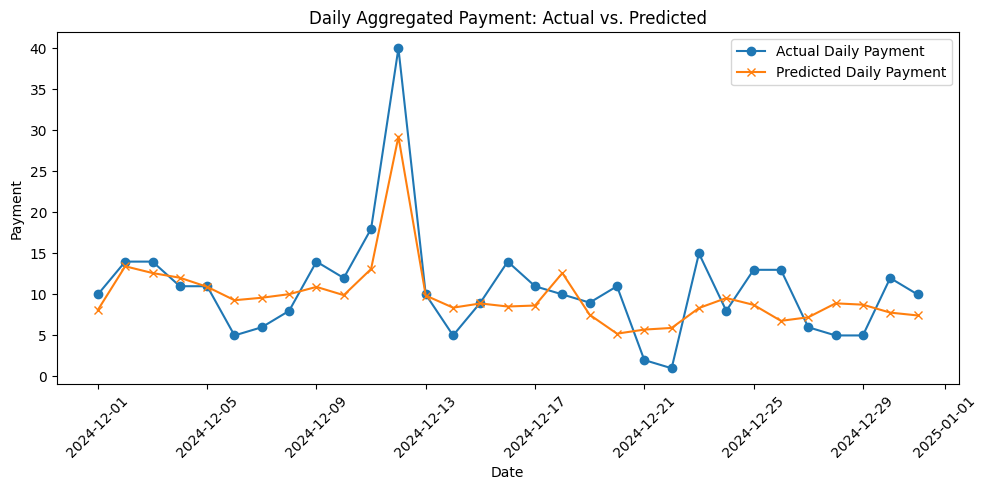

In [22]:
val_df = demand[(demand['date'] >= '2024-12-01') & (demand['date'] <= '2024-12-31')].copy()

# Ensure val_df is sorted by date for a proper line plot
val_df.sort_values(by='date', inplace=True)

val_df['predicted_payment'] = test_preds

# 1) Aggregate payments by date
daily_agg = (
    val_df
    .groupby('date', as_index=False)
    .agg({'payment': 'sum', 'predicted_payment': 'sum'})
    .rename(columns={
        'payment': 'actual_daily_payment',
        'predicted_payment': 'predicted_daily_payment'
    })
)

# 2) Ensure chronological order
daily_agg.sort_values('date', inplace=True)

# 3) Plot both series on the same line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_agg['date'], daily_agg['actual_daily_payment'], marker='o', label='Actual Daily Payment')
plt.plot(daily_agg['date'], daily_agg['predicted_daily_payment'], marker='x', label='Predicted Daily Payment')
plt.xlabel('Date')
plt.ylabel('Payment')
plt.title('Daily Aggregated Payment: Actual vs. Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Importance

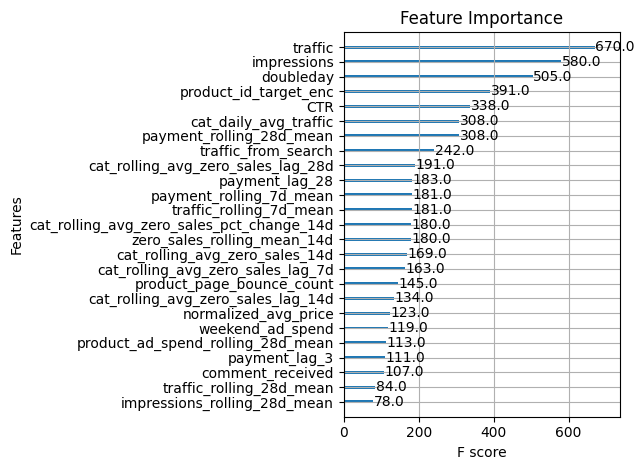

In [23]:
xgb.plot_importance(model, max_num_features=25)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### Save the model to a file

In [24]:
model.save_model('ecom_pred_xgboost_model.json')

# Later, you can load it back like this:
# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

## Predict unknown date: Jan 2025
TBU